Choose file to use as input.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_index = 8
data_files = [
    ('data/krwusd_1994-2024.csv', 'KRW/USD (1994-2024)'), # 0
    ('data/krwusd_2004-2024.csv', 'KRW/USD (2004-2024)'), # 1
    ('data/krwusd_2014-2024.csv', 'KRW/USD (2014-2024)'), # 2
    ('data/krwusd_2019-2024.csv', 'KRW/USD (2019-2024)'), # 3
    ('data/krwpln_1994-2024.csv', 'KRW/PLN (1994-2024)'), # 4
    ('data/krwpln_2004-2024.csv', 'KRW/PLN (2004-2024)'), # 5
    ('data/krwpln_2014-2024.csv', 'KRW/PLN (2014-2024)'), # 6
    ('data/krwpln_2019-2024.csv', 'KRW/PLN (2019-2024)'), # 7
    ('data/cdr.csv', 'CDR (1994-2024)'), # 8
]
file_name = data_files[file_index][0]
title = data_files[file_index][1]

Load and display the data

In [51]:
data = pd.read_csv(file_name)[['<DATE>', '<CLOSE>']]
data = data.rename(columns={'<DATE>': 'Date', '<CLOSE>': 'Value'})
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
display(data)

,Date,Value
0,1994-08-02,7.90337
1,1994-08-03,8.68064
2,1994-08-04,9.54149
3,1994-08-08,8.68064
4,1994-08-09,10.24570
...,...,...
7344,2024-02-21,113.50000
7345,2024-02-22,115.45000
7346,2024-02-23,114.85000
7347,2024-02-26,113.90000


Show exchange rate plot

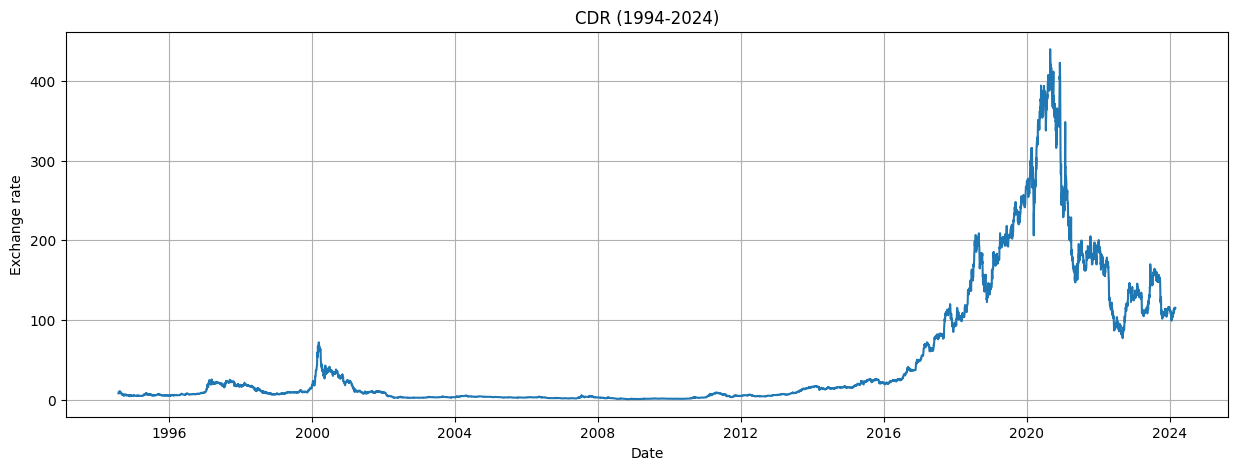

In [52]:
def plot_exchange_rate(data, title):
    plt.figure(figsize=(15, 5))
    plt.plot(data['Date'], data['Value'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Exchange rate')
    plt.grid()
    plt.show()

plot_exchange_rate(data, title)

Define `EMA`, `MACD` and `SIGNAL` functions

In [53]:
def EMA(data: pd.Series, start_index: int, n: int) -> float:
    alfa = 2 / (n + 1)
    nominator = 0.0
    denominator = 0.0
    counter = 0
    for i in range(start_index, start_index-n-1, -1):
        if i < 0:
            raise ValueError(f'N={n} is too large for index={start_index}')
        if np.isnan(data[i]):
            raise ValueError(f'Value at index {i} is NaN')

        nominator += data[i] * (1 - alfa)**counter
        denominator += (1 - alfa)**counter
        counter += 1

    return nominator / denominator

def MACD(data: pd.Series, index: int) -> float:
    return EMA(data, index, 12) - EMA(data, index, 26)

def SIGNAL(data: pd.Series, index: int) -> float:
    return EMA(data, index, 9)

Calculate MACD and SIGNAL values. Find the points where MACD crosses SIGNAL.

In [54]:
for record in data.iterrows():
    index = record[0]

    if index < 26:
        continue
    macd = MACD(data['Value'], index)
    data.at[index, 'MACD'] = macd
    
    if index < 35:
        continue
    signal = SIGNAL(data['MACD'], index)
    data.at[index, 'SIGNAL'] = signal

    prev_macd = data.at[index-1, 'MACD']
    prev_signal = data.at[index-1, 'SIGNAL']
    if np.isnan(prev_macd) or np.isnan(prev_signal):
        continue

    if prev_macd < prev_signal and macd > signal:
        data.at[index, 'Action'] = 'BUY'
    elif prev_macd > prev_signal and macd < signal:
        data.at[index, 'Action'] = 'SELL'

data[data['Action'].notna()]

,Date,Value,MACD,SIGNAL,Action
49,1994-10-24,5.53426,0.041454,0.054359,SELL
65,1994-11-18,5.42191,-0.166226,-0.169063,BUY
66,1994-11-21,4.86945,-0.189209,-0.174694,SELL
72,1994-11-29,5.35630,-0.253908,-0.284398,BUY
80,1994-12-09,4.45734,-0.062594,-0.053543,SELL
...,...,...,...,...,...
7283,2023-11-23,110.40000,1.811016,1.958908,SELL
7295,2023-12-11,113.85000,-0.306446,-0.493560,BUY
7308,2024-01-02,111.90000,1.351125,1.628432,SELL
7325,2024-01-25,106.35000,-2.857437,-3.196152,BUY


Show MACD and SIGNAL plot

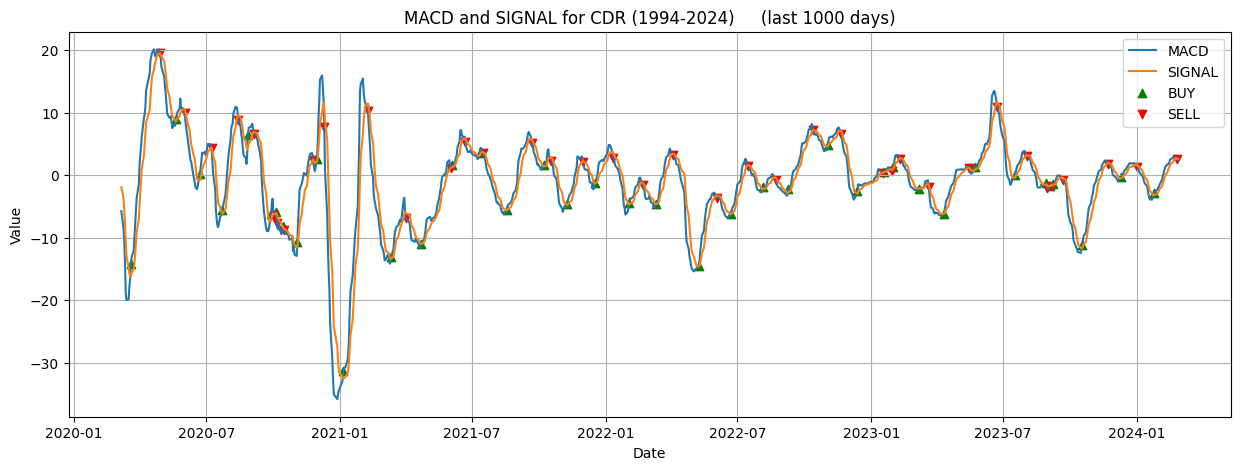

In [55]:
def plot_MACD_and_SIGNAL(data, title='MACD and SIGNAL'):
    buy_data = data[data['Action'] == 'BUY']
    sell_data = data[data['Action'] == 'SELL']

    plt.figure(figsize=(15, 5))
    plt.plot(data['Date'], data['MACD'])
    plt.plot(data['Date'], data['SIGNAL'])
    plt.scatter(buy_data['Date'], buy_data['MACD'], color='green', marker='^')
    plt.scatter(sell_data['Date'], sell_data['MACD'], color='red', marker='v')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid()
    plt.legend(['MACD', 'SIGNAL', 'BUY', 'SELL'])
    plt.show()
    
days_count = 1000
tailed_data = data.tail(days_count)
plot_MACD_and_SIGNAL(tailed_data, title=f'MACD and SIGNAL for {title}     (last {min(days_count, len(data))} days)')

Simulate trading using MACD and SIGNAL.

In [56]:
initial_balance = 1_000
instrument_balance = initial_balance
alt_balance = 0

for record in tailed_data.iterrows():
    index = record[0]
    record_data = record[1]

    if record_data['Action'] == 'BUY':
        if alt_balance == 0:
            continue
        instrument_bought = alt_balance / record_data['Value']
        instrument_balance += instrument_bought
        alt_balance = 0
    elif record_data['Action'] == 'SELL':
        if instrument_balance == 0:
            continue
        alt_bought = instrument_balance * record_data['Value']
        alt_balance += alt_bought
        instrument_balance = 0

if alt_balance > 0:
    last_value = tailed_data.tail(1)['Value'].values[0]
    instrument_balance += alt_balance / last_value
    alt_balance = 0


print(f'Initial balance: {initial_balance:.2f}')
print(f'Final balance: {instrument_balance:.2f}')
print(f'Profit: {instrument_balance - initial_balance:.2f} ({(instrument_balance - initial_balance) / initial_balance * 100:.2f}%)')

Initial balance: 1000.00
Final balance: 2488.95
Profit: 1488.95 (148.89%)
